In [8]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
HERMES_MODEL_STATE_DICT_PATH=os.getenv("HERMES_MODEL_STATE_DICT_PATH")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.hermes_encoder import HermesEncoder
from mmwave_model_integrator.ground_truth_encoders.hermes_gt_encoder import HermesGTEncoder
from mmwave_model_integrator.plotting.plotter_hermes import PlotterHermes
from mmwave_model_integrator.dataset_generators.hermes_dataset_generator import HermesDatasetGenerator

from mmwave_model_integrator.model_runner.hermes_runner import HermesRunner
from mmwave_model_integrator.decoders.heremes_decoder import HermesDecoder
from mmwave_model_integrator.plotting.movie_generator_hermes import MovieGeneratorHermes
from mmwave_model_integrator.analyzers.analyzer_hermes import AnalyzerHermes

In [9]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"1843_RadVel_10Hz_lr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [10]:
#load the dataset
#determine the paths to all of the datasets
dataset_name = "hermes_north_vicon_1"
dataset_path = os.path.join(MODEL_TRAINING_DATASET_PATH,"Hermes",dataset_name)

dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="front_radar_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full",
    vehicle_odom_folder="vehicle_odom"
)

found 1065 radar samples
found 1065 lidar samples
did not find camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 1065 vehicle velocity samples
found 1065 vehicle odometry samples


In [11]:
input_encoder = HermesEncoder(
    config_manager=cfg_manager,
    az_angle_bins_rad=np.deg2rad(np.linspace(
        start=-90,stop=90,num=90
    )),
    num_frames=5,
    stride=1,
    min_vel=np.array([0.00,0.30,0.0]),
    max_vel=np.array([0.1,0.70,0.1]), #np.array([0.05,0.50,0.05]),
    max_vel_stdev=np.array([0.02,0.02,0.02]), #np.array([0.02,0.02,0.02]),
    power_threshold_dB=20
)

ground_truth_encoder = HermesGTEncoder(
    hermes_encoder=input_encoder,
    candidate_points_threshold=0.05,
    valid_points_distance_threshold_m=1.0
)

plotter = PlotterHermes()

input_dimmensions = (64,128)
runner = HermesRunner(
    state_dict_path=os.path.join(HERMES_MODEL_STATE_DICT_PATH,"hermes_mini.pth"),
    cuda_device="cpu",
    input_dimmensions=input_dimmensions,
    encoder_out_channels = (64,128),
    decoder_input_channels = (256,128)
)

prediction_decoder = HermesDecoder(
    input_encoder=input_encoder,
    output_size=np.array(input_dimmensions)
)

analyzer = AnalyzerHermes(
    cpsl_dataset=dataset,
    input_encoder=input_encoder,
    model_runner=runner,
    prediction_decoder=prediction_decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.getenv("ANALYZER_TEMP_DIRECTORY")
)

_ModelRunner: using CPU
Total number of parameters: 1864257


In [12]:
datasets = [
    "hermes_north_vicon_1",
    "hermes_north_vicon_2",
    "hermes_north_vicon_3",
    "hermes_north_vicon_4",
    "hermes_north_vicon_5",
    "hermes_north_vicon_6",
    "hermes_north_vicon_7",
]

chamfer_dists_radar_hd = []
chamfer_dists = []
hausdorff_dists = []
modified_hausdorff_distances_radarHD = []

for i in range(len(datasets)):
    dataset_name = datasets[i]
    
    chamfer_dist_radar_hd = np.load("{}_chamfer_radarHD.npy".format(dataset_name))
    chamfer_dist = np.load("{}_chamfer.npy".format(dataset_name))
    hausdorff_dist = np.load("{}_hausdorf.npy".format(dataset_name))
    modified_hausdorff_distance_radarHD = np.load("{}_hausdorff_radarHD.npy".format(dataset_name))

    chamfer_dists_radar_hd.append(chamfer_dist_radar_hd)
    chamfer_dists.append(chamfer_dist)
    hausdorff_dists.append(hausdorff_dist)
    modified_hausdorff_distances_radarHD.append(modified_hausdorff_distance_radarHD)


chamfer_dists_radar_hd = np.concatenate(chamfer_dists_radar_hd)
chamfer_dists = np.concatenate(chamfer_dists)
hausdorff_dists = np.concatenate(hausdorff_dists)
modified_hausdorff_distances_radarHD = np.concatenate(modified_hausdorff_distances_radarHD)



In [13]:
# chamfer,hausdorff, chamfer_radarHD, modified_hausdorff_radarHD = \
#     analyzer.compute_all_distance_metrics(
#         save_to_file=True,
#         file_name=dataset_name
#     )
analyzer.show_all_summary_statistics(
    # chamfer_distances=chamfer_dists,
    # hausdorff_distances=hausdorff_dists,
    chamfer_distances_radarHD=chamfer_dists_radar_hd,
    modified_hausdorff_distances_radarHD=modified_hausdorff_distances_radarHD
)

,Metric,Hausdorff,Modified Hausdorff (radarHD),Chamfer,Chamfer (radarHD)
0,Mean,0,0.193955,0,0.360668
1,Median,0,0.094134,0,0.261162
2,90th percentile,0,0.549177,0,0.796061


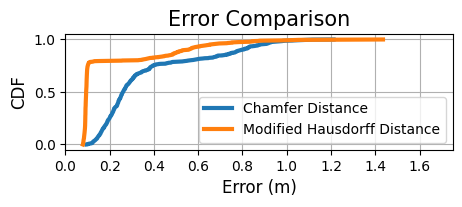

In [14]:
plotter.plot_distance_metrics_cdfs(
    # chamfer_distances=chamfer,
    # hausdorf_distances=hausdorff,
    chamfer_distances_radarHD=chamfer_dists_radar_hd,
    modified_hausdorf_distances_radarHD=modified_hausdorff_distances_radarHD
)